In [5]:
import requests as rq
from bs4 import BeautifulSoup as bs
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from IPython import display

from tqdm import tqdm

In [6]:
class lentaRu_parser:
    def __init__(self):
        pass
    
    
    def _get_url(self, param_dict: dict) -> str:
        """
        Возвращает URL для запроса json таблицы со статьями

        url = 'https://lenta.ru/search/v2/process?'\
        + 'from=0&'\                       # Смещение
        + 'size=1000&'\                    # Кол-во статей
        + 'sort=2&'\                       # Сортировка по дате (2), по релевантности (1)
        + 'title_only=0&'\                 # Точная фраза в заголовке
        + 'domain=1&'\                     # ??
        + 'modified%2Cformat=yyyy-MM-dd&'\ # Формат даты
        + 'type=1&'\                       # Материалы. Все материалы (0). Новость (1)
        + 'bloc=4&'\                       # Рубрика. Экономика (4). Все рубрики (0)
        + 'modified%2Cfrom=2020-01-01&'\
        + 'modified%2Cto=2020-11-01&'\
        + 'query='                         # Поисковой запрос
        """
        hasType = int(param_dict['type']) != 0
        hasBloc = int(param_dict['bloc']) != 0

        url = 'https://lenta.ru/search/v2/process?'\
        + 'from={}&'.format(param_dict['from'])\
        + 'size={}&'.format(param_dict['size'])\
        + 'sort={}&'.format(param_dict['sort'])\
        + 'title_only={}&'.format(param_dict['title_only'])\
        + 'domain={}&'.format(param_dict['domain'])\
        + 'modified%2Cformat=yyyy-MM-dd&'\
        + 'type={}&'.format(param_dict['type']) * hasType\
        + 'bloc={}&'.format(param_dict['bloc']) * hasBloc\
        + 'modified%2Cfrom={}&'.format(param_dict['dateFrom'])\
        + 'modified%2Cto={}&'.format(param_dict['dateTo'])\
        + 'query={}'.format(param_dict['query'])
        
        return url


    def _get_search_table(self, param_dict: dict) -> pd.DataFrame:
        """
        Возвращает pd.DataFrame со списком статей
        """
        url = self._get_url(param_dict)
        r = rq.get(url)
        search_table = pd.DataFrame(r.json()['matches'])
        
        return search_table

    
    def get_articles(self,
                     param_dict,
                     time_step = 10,
                     save_every = 5, 
                     save_excel = True) -> pd.DataFrame:
        """
        Функция для скачивания статей интервалами через каждые time_step дней
        Делает сохранение таблицы через каждые save_every * time_step дней

        param_dict: dict
        ### Параметры запроса 
        ###### project - раздел поиска, например, rbcnews
        ###### category - категория поиска, например, TopRbcRu_economics
        ###### dateFrom - с даты
        ###### dateTo - по дату
        ###### offset - смещение поисковой выдачи
        ###### limit - лимит статей, максимум 100
        ###### query - поисковой запрос (ключевое слово), например, РБК

        """
        param_copy = param_dict.copy()
        time_step = timedelta(days=time_step)
        dateFrom = datetime.strptime(param_copy['dateFrom'], '%Y-%m-%d')
        dateTo = datetime.strptime(param_copy['dateTo'], '%Y-%m-%d')
        if dateFrom > dateTo:
            raise ValueError('dateFrom should be less than dateTo')
        
        out = pd.DataFrame()
        save_counter = 0

        while dateFrom <= dateTo:
            param_copy['dateTo'] = (dateFrom + time_step).strftime('%Y-%m-%d')
            if dateFrom + time_step > dateTo:
                param_copy['dateTo'] = dateTo.strftime('%Y-%m-%d')
            print('Parsing articles from '\
                  + param_copy['dateFrom'] +  ' to ' + param_copy['dateTo'])
            out = pd.concat([out, self._get_search_table(param_copy)], axis=0, ignore_index=True)
            dateFrom += time_step + timedelta(days=1)
            param_copy['dateFrom'] = dateFrom.strftime('%Y-%m-%d')
            save_counter += 1
            if save_counter == save_every:
                display.clear_output(wait=True)
                out.to_csv("checkpoint_table_3.scv", index=False)
                print('Checkpoint saved!')
                save_counter = 0
        
        return out

In [7]:
# Задаем тут параметры
use_parser = "LentaRu"

query = ''
offset = 0
size = 500
sort = "3"
title_only = "0"
domain = "1"
material = "0"
bloc = "4"
dateFrom = '2005-01-01'
dateTo = "2010-01-01"

if use_parser == "LentaRu":
    param_dict = {'query'     : query, 
                  'from'      : str(offset),
                  'size'      : str(size),
                  'dateFrom'  : dateFrom,
                  'dateTo'    : dateTo,
                  'sort'      : sort,
                  'title_only': title_only,
                  'type'      : material, 
                  'bloc'      : bloc,
                  'domain'    : domain}

print(use_parser, "- param_dict:", param_dict)

LentaRu - param_dict: {'query': '', 'from': '0', 'size': '500', 'dateFrom': '2005-01-01', 'dateTo': '2010-01-01', 'sort': '3', 'title_only': '0', 'type': '0', 'bloc': '4', 'domain': '1'}


In [10]:
assert use_parser == "LentaRu"
parser = lentaRu_parser()
tbl = parser.get_articles(param_dict=param_dict,
                         time_step = 5,
                         save_every = 5, 
                         save_excel = True)
print(len(tbl.index))
tbl.head()

Checkpoint saved!
28833


,rightcol,docid,lastmodtime,part,title,type,url,tags,bloc,domain,modified,image_url,text,status,pubdate,snippet
0,C началом 2005 года в Турции началась деномина...,248467,1670495340,0,Турецкая лира потеряла шесть нулей,1,https://lenta.ru/news/2005/01/01/zeros/,[],4,1,1104590140,https://icdn.lenta.ru/images/0000/0204/0000020...,Банкнота в 20 миллионов турецких лир. Иллюстра...,0,1104590140,Банкнота в 20 миллионов турецких лир. Иллюстра...
1,"В пятницу НК ""ЮКОС"" обвинила государственную к...",248449,1670495339,0,"""ЮКОС"" обвинил ""Роснефть"" в экспроприации ""Юга...",1,https://lenta.ru/news/2005/01/01/expropriate/,[],4,1,1104598959,https://icdn.lenta.ru/images/0000/0204/0000020...,"Вывеска на офисе ""Роснефти"". Фото Reuters, арх...",0,1104598959,"Вывеска на офисе ""Роснефти"". Фото Reuters, арх..."
2,Джеймс Вулфенсон является девытым по счету пре...,248585,1670495344,0,Глава Всемирного банка собрался в отставку,1,https://lenta.ru/news/2005/01/02/wolfensohn/,[],4,1,1104704312,https://icdn.lenta.ru/images/0000/0204/0000020...,"Джеймс Вулфенсон. Кадр телекананала ""Россия"", ...",0,1104704312,"Джеймс Вулфенсон. Кадр телекананала ""Россия"", ..."
3,Компания пошла на пересмотр ценовой политики и...,249062,1670495363,0,Delta Air Lines снижает цены на билеты,1,https://lenta.ru/news/2005/01/03/delta/,[],4,1,1104722459,https://icdn.lenta.ru/images/0000/0204/0000020...,Самолет компании Delta Air Lines. Фото Reuters...,0,1104722459,Самолет компании Delta Air Lines. Фото Reuters...
4,. Такое заявление сделал в понедельник министр...,248957,1670495358,0,Южнокорейские ИТ-компании доведут объем экспор...,1,https://lenta.ru/news/2005/01/03/it/,[],4,1,1104759489,https://icdn.lenta.ru/images/0000/0204/0000020...,Флаг Южной Кореи Объем экспорта южнокорейских ...,0,1104759489,Флаг Южной Кореи Объем экспорта ... в 2005 год...


In [11]:
data = pd.read_csv('lenta_2005-2025.csv')
data['date'] = pd.to_datetime(data['pubdate'], unit='s')
texts = data[['date', 'title', 'text', 'url']]
texts.sort_values(by = ['date'], ignore_index=True)
texts

,date,title,text,url
0,2010-01-01 14:45:29,Приказ о минимальной цене на водку вступил в силу,"Кадр ТВ-6, архив C 1 января 2010 года в России...",https://lenta.ru/news/2010/01/01/vodka/
1,2010-01-02 09:14:58,Fox и Time Warner Cable согласовали плату за т...,Штаб-квартира Time Warner в Нью-Йорке. Фото (c...,https://lenta.ru/news/2010/01/02/deal/
2,2010-01-03 03:09:44,Исландцы выразили протест против выплат компен...,Штаб-квартира Landsbanki. Фото (c)AFP Четверть...,https://lenta.ru/news/2010/01/03/iceland/
3,2010-01-03 15:36:03,Борцовский клуб,Фото (c)AFP Ирина Рябова Для российской эконом...,https://lenta.ru/articles/2010/01/03/finalecorus/
4,2010-01-03 19:29:06,Трейдеры сообщили о прекращении поставок росси...,Мозырский НПЗ. Фото (c)AFP Россия прекратила п...,https://lenta.ru/news/2010/01/03/oil/
...,...,...,...,...
151210,2009-12-30 23:51:58,Бернарда Мейдоффа выписали из больницы,Бернард Мейдофф. Фото (c)AFP Американский фина...,https://lenta.ru/news/2009/12/30/madoff/
151211,2009-12-31 11:17:15,"Международные резервы РФ сократились на 2,7 ми...","Здание ЦБ РФ. Фото ""Ленты.Ру"" Международные ре...",https://lenta.ru/news/2009/12/31/reserve/
151212,2009-12-31 17:15:26,"""Газпром"" назвал дату начала поставок туркменс...","Вид на здание ""Газпрома"" в Москве. Фото (c)AFP...",https://lenta.ru/news/2009/12/31/trkgas/
151213,2009-12-31 21:43:36,Россия и Белоруссия не договорились о поставка...,Нефтепровод в Белоруссии. Фото (c)AFP Перегово...,https://lenta.ru/news/2009/12/31/postpone/


## Plot the number of articles per year

In [12]:
texts['month'] = texts['date'].dt.month.astype(str)
texts['month'] = texts['month'].apply(lambda x: '0'+x if len(x)==1 else x)
texts['year'] = texts['date'].dt.year.astype(str)
texts['month-year'] =  texts['year'] + '-' + texts['month'] 
texts

/tmp/ipykernel_765731/699328171.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  texts['month'] = texts['date'].dt.month.astype(str)
/tmp/ipykernel_765731/699328171.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  texts['month'] = texts['month'].apply(lambda x: '0'+x if len(x)==1 else x)
/tmp/ipykernel_765731/699328171.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

,date,title,text,url,month,year,month-year
0,2010-01-01 14:45:29,Приказ о минимальной цене на водку вступил в силу,"Кадр ТВ-6, архив C 1 января 2010 года в России...",https://lenta.ru/news/2010/01/01/vodka/,01,2010,2010-01
1,2010-01-02 09:14:58,Fox и Time Warner Cable согласовали плату за т...,Штаб-квартира Time Warner в Нью-Йорке. Фото (c...,https://lenta.ru/news/2010/01/02/deal/,01,2010,2010-01
2,2010-01-03 03:09:44,Исландцы выразили протест против выплат компен...,Штаб-квартира Landsbanki. Фото (c)AFP Четверть...,https://lenta.ru/news/2010/01/03/iceland/,01,2010,2010-01
3,2010-01-03 15:36:03,Борцовский клуб,Фото (c)AFP Ирина Рябова Для российской эконом...,https://lenta.ru/articles/2010/01/03/finalecorus/,01,2010,2010-01
4,2010-01-03 19:29:06,Трейдеры сообщили о прекращении поставок росси...,Мозырский НПЗ. Фото (c)AFP Россия прекратила п...,https://lenta.ru/news/2010/01/03/oil/,01,2010,2010-01
...,...,...,...,...,...,...,...
151210,2009-12-30 23:51:58,Бернарда Мейдоффа выписали из больницы,Бернард Мейдофф. Фото (c)AFP Американский фина...,https://lenta.ru/news/2009/12/30/madoff/,12,2009,2009-12
151211,2009-12-31 11:17:15,"Международные резервы РФ сократились на 2,7 ми...","Здание ЦБ РФ. Фото ""Ленты.Ру"" Международные ре...",https://lenta.ru/news/2009/12/31/reserve/,12,2009,2009-12
151212,2009-12-31 17:15:26,"""Газпром"" назвал дату начала поставок туркменс...","Вид на здание ""Газпрома"" в Москве. Фото (c)AFP...",https://lenta.ru/news/2009/12/31/trkgas/,12,2009,2009-12
151213,2009-12-31 21:43:36,Россия и Белоруссия не договорились о поставка...,Нефтепровод в Белоруссии. Фото (c)AFP Перегово...,https://lenta.ru/news/2009/12/31/postpone/,12,2009,2009-12


In [13]:
counts = texts.groupby(by = ['month-year'])['title'].count().reset_index()
counts.columns = ['month-year', 'count']
counts.describe()

,count
count,239.000000
mean,632.698745
std,410.361873
min,174.000000
25%,382.000000
50%,494.000000
75%,719.000000
max,2418.000000


<Axes: title={'center': 'Monthly Count of Economic Articles (Lenta)'}, xlabel='month-year'>

<Figure size 2000x800 with 0 Axes>

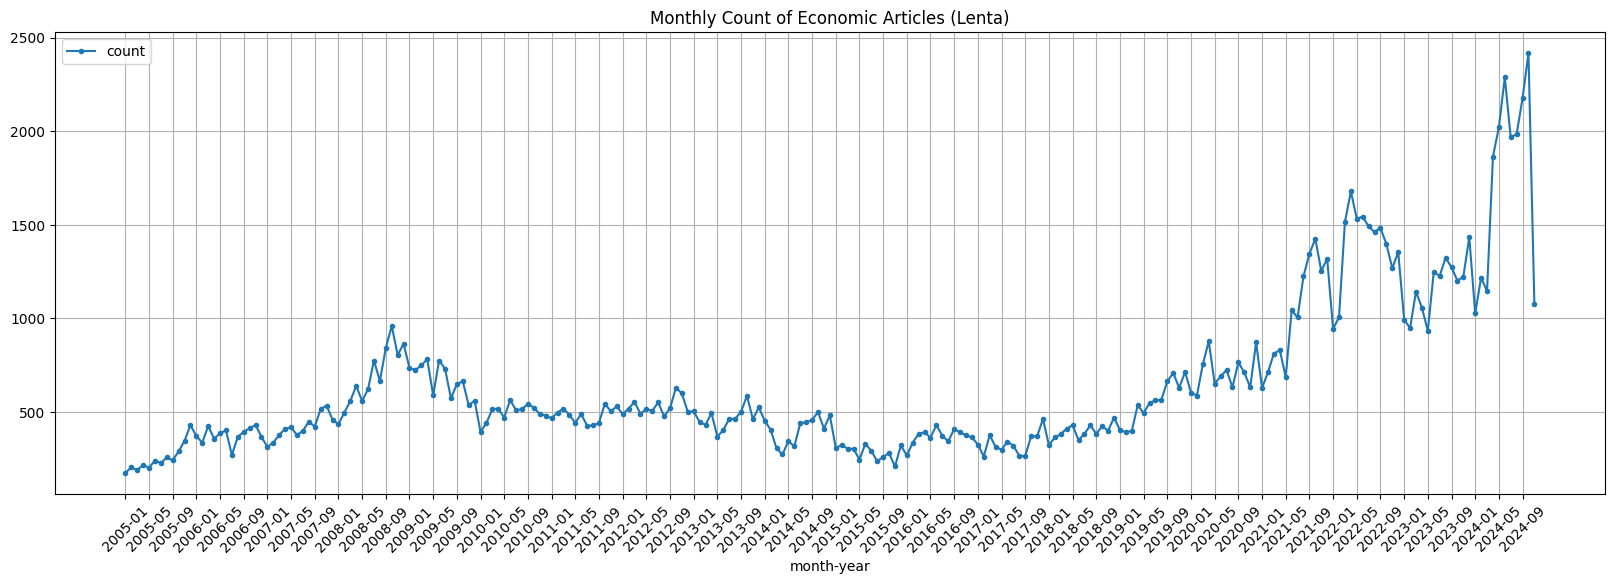

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,8))

counts = counts.sort_values(by = ['month-year'])
counts.set_index('month-year').plot(
    style='.-',
    figsize=(20,6),
    xticks = list(counts.index)[::4],
    rot=45,
    title='Monthly Count of Economic Articles (Lenta)',
    grid=True)